<a href="https://colab.research.google.com/github/apmotgi16/NYGroceryPlacement/blob/master/NYGroceryPlacement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 192 Final Project
## *Abhi Motgi & Ciara Brown*
Computing the ideal locations of 190 grocery stores in New York City based on population demand

## 1. Loading & Preparing Datasets
The main datasets we used are:

*   NYC Retail Food Stores.csv - contains 22,000+ rows of food stores in New York State
*  NYC Retail Food Stores COORDINATES.csv - contains geocoded latitude and longitudes of NYC stores
*  New_York_City_Population_By_Census_Tracts.csv - contains 2010 census data with population and tracts
*  2017_ny_tracts.csv - contains FIPS codes / counties and tracts for computing lat & long of population points




### 1a. Importing Data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

stores = pd.read_csv('NYC Retail Food Stores COORDINATES.csv')
store_list = stores[['LAT', 'LONG']].values.T.tolist()

population = pd.read_csv('New_York_City_Population_By_Census_Tracts.csv', skiprows=0)
ny_coords = pd.read_csv('2017_ny_tracts.csv', skiprows=0)

#merge datasets on GEOID (fips code)
big_pop = pd.merge(population, ny_coords, on='GEOID', how='inner')

#select pop & coordinates into list
pop_list = big_pop[['Population', 'INTPTLAT', 'INTPTLONG']].values.T.tolist()

### 1b. Preparing Data

Population of NYC is ~8 million. scikit-learn doesn't support weighted k-means cluster so instead of weighing each GPS coordinate with n (n = population in county), we have to create a list where each GPS coordinate occurs in the list n times 


In [0]:
import random

big_coords_list = []

for i in range(len(pop_list[0])):
  while (pop_list[0][i] > 0):
    big_coords_list.append([pop_list[1][i], pop_list[2][i]])
    pop_list[0][i] -= 1


## 2. Computing Ideal Store Locations using K-Means Clustering

There are over 14,000 grocery stores in New York City but because many of them are within 100 feet, they have the same gps coordinates. As a result, our dataset contains 190 unique latitudes and longitudes. We thus ran the k-means clustering on the population data with k=190 to compute where the ideal grocery stores should be located. We randomly sample 1 million points of population data (out of 8 million) to limit the computation we have to do.

*Takes ~6 minutes to run*

In [44]:
import matplotlib.pyplot as plt  
import random
%matplotlib inline
import numpy as np  
from sklearn.cluster import KMeans  

#random sample coordinates
coords_list = random.sample(big_coords_list, 1000000)

# put long, lat coordinate pairs here
X = np.array(coords_list)

kmeans = KMeans(n_clusters=190, max_iter = 10)  
kmeans.fit(X) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
    n_clusters=190, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## 3. Analyzing Our Results

Custom class for plotting line-scatter graphs to see how final analysis did

In [0]:
import matplotlib.pyplot as plt

class MakeGraph(object):
  def __init__(self, xList, yList):
    df = pd.DataFrame({'xVals': xList, 'yVals': yList})
    plt.plot('xVals', 'yVals', data=df, linestyle='-', marker='o', color='black')
    plt.xlabel('Cumulative Population Size')
    plt.ylabel('Average Minimum Distance in Miles')
    

### 3a. Plotting population data, k-means clusters, and actual stores


*   Colorful dots = population data (1 million points but many effectively on top of each other)
*   Translucent black circles = clusters (190 points)
*   Yellow squares = actual store locations (190 points)

*Takes ~1 minute to run*


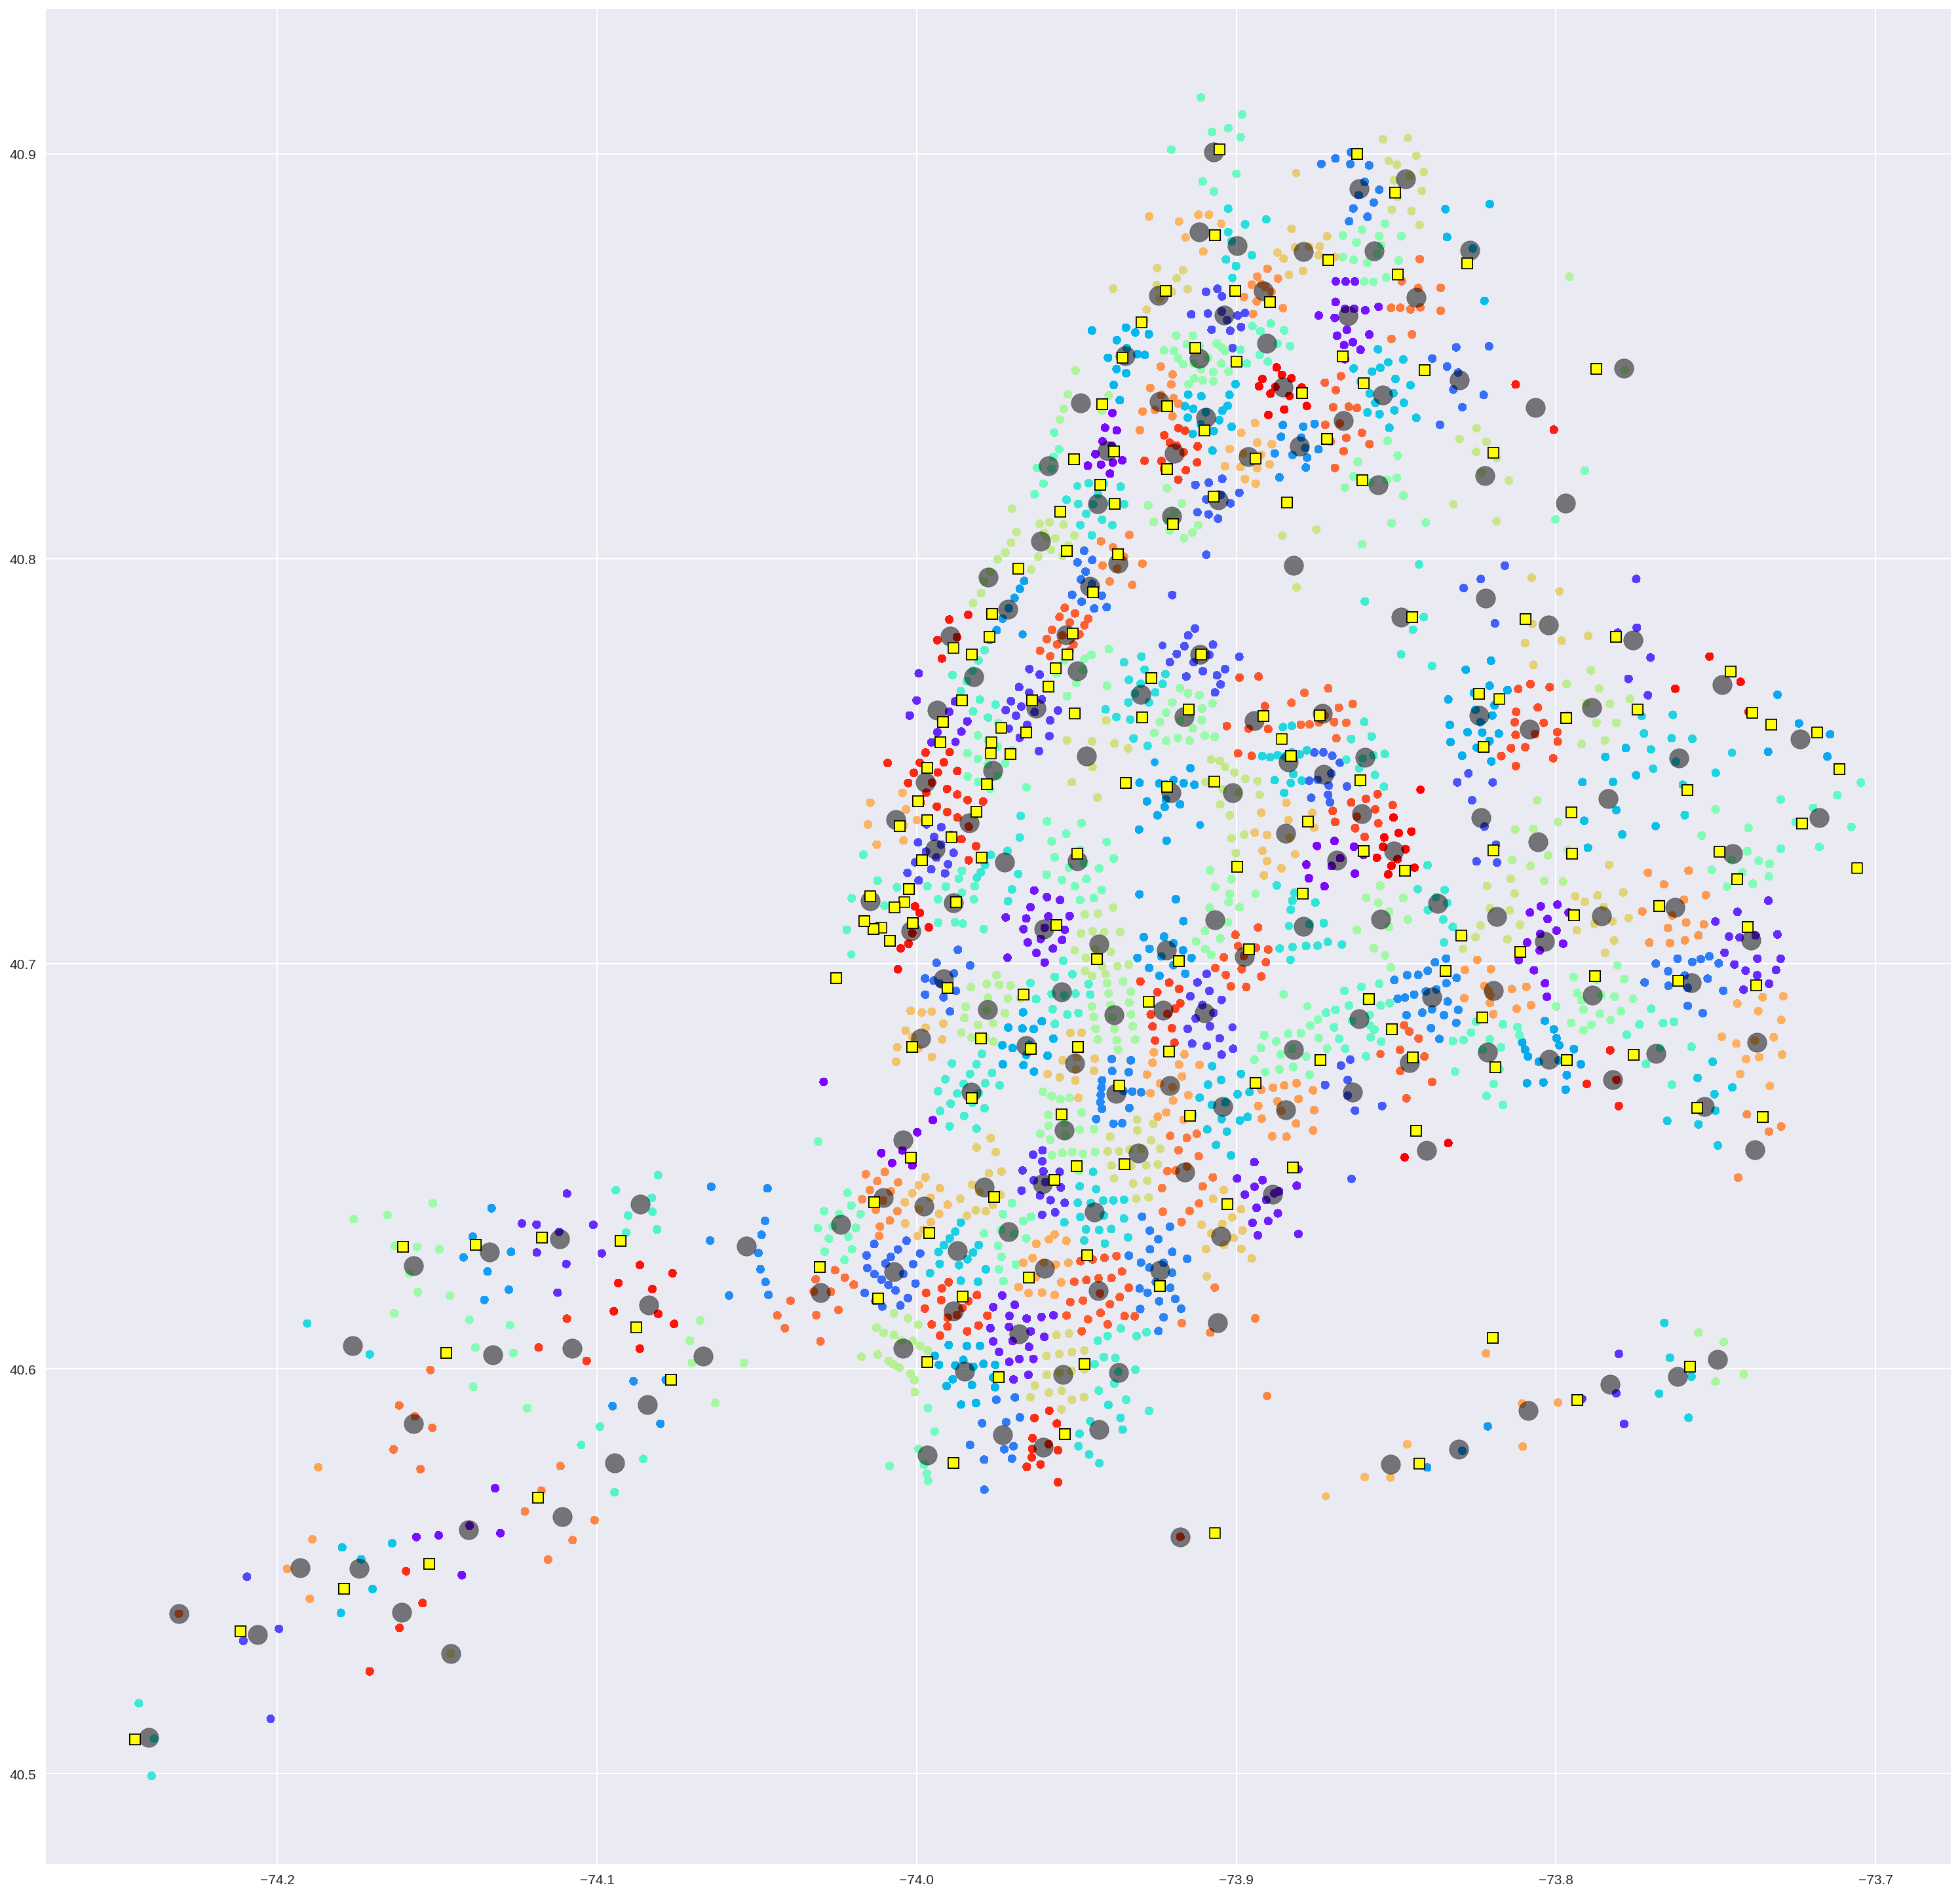

In [46]:
import matplotlib.pyplot as plt  
import collections
import random

plt.figure(figsize=(25, 25), dpi=150)

#plot population
plt.scatter(X[:,1],X[:,0], c=kmeans.labels_, cmap='rainbow', s=30)

# plot the calculated cluster centers
plt.scatter(kmeans.cluster_centers_[:,1] ,kmeans.cluster_centers_[:,0], color='black', s = 200, alpha = 0.5)  

#plot existing retail stores
plt.scatter(store_list[1], store_list[0], s=60, color='yellow', edgecolors='black', linewidths=0.75, marker='s')

### 3b. Computing Average Minimum Distance between People and 190 Computed Clusters

We sample 5000 random people from our list of 8 million, find the closest store to them, and then save that result. We then compute the average distance of the closest store for our 5000 people and plot that using `MakeGraph()`

*Takes about ~4 minutes*

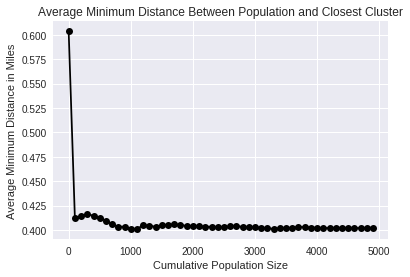

In [47]:
import geopy.distance as gp
import matplotlib.pyplot as plt
import random


# get 5000 random people
x_sampled = random.sample(big_coords_list, 5000)

x_cumpop = []
y_avgdist = []

runningSum = 0

for i in range(len(x_sampled)):
  longPop = x_sampled[i][1]
  latPop = x_sampled[i][0]
  coordsPop = (latPop, longPop)
  minDistance = 1000
  
  for j in range(len(kmeans.cluster_centers_)):
    longCluster = kmeans.cluster_centers_[j][1]
    latCluster = kmeans.cluster_centers_[j][0]
    coordsCluster = (latCluster, longCluster)
    minDistance = min(minDistance, gp.distance(coordsCluster, coordsPop).miles)
      
  runningSum += minDistance
  
  if (i % 100 == 0):
    x_cumpop.append(i)
    y_avgdist.append(runningSum / (i+1))

MakeGraph(x_cumpop, y_avgdist)
plt.title('Average Minimum Distance Between Population and Closest Cluster')
plt.show()



### 3c. Computing Average Minimum Distance between People and 190 Unique Existing Stores

*Takes about ~4 minutes*

Text(0.5,1,'Average Minimum Distance Between Population and Closest Existing Store')

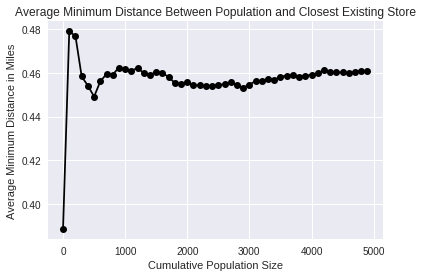

In [48]:
import geopy.distance as gp
import matplotlib.pyplot as plt
import random

# get 5000 random people
x_sampled = random.sample(big_coords_list, 5000)

x_cumpop = []
y_avgdist = []

runningSum = 0

uniqueStores = list(set(zip(store_list[0],store_list[1])))

for i in range(len(x_sampled)):
  longPop = coords_list_2[i][1]
  latPop = coords_list_2[i][0]
  coordsPop = (latPop, longPop)
  minDistance = 1000
  
  for j in range(len(uniqueStores)):
    longCluster = uniqueStores[j][1]
    latCluster = uniqueStores[j][0]
    coordsCluster = (latCluster, longCluster)
    minDistance = min(minDistance, gp.distance(coordsCluster, coordsPop).miles)

  runningSum += minDistance
  
  if (i % 100 == 0):
    x_cumpop.append(i)
    y_avgdist.append(runningSum / (i+1))

MakeGraph(x_cumpop, y_avgdist)
plt.title('Average Minimum Distance Between Population and Closest Existing Store')